In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

c:\Users\dmitr\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Подготовка данных

Информация о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [2]:
active_studs = pd.read_csv('active_studs.csv')
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


Файл с информацией об оплатах пользователей в дни проведения эксперимента

In [3]:
checks = pd.read_csv('checks.csv', sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [4]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

Дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [5]:
group_add = pd.read_csv('group_add.csv')
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


Информация о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [6]:
groups = pd.read_csv('groups.csv', sep=';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [7]:
groups.dtypes

id      int64
grp    object
dtype: object

Для анализа результатов эксперимента проверим значения CR, ARPU (Average revenue per user), средний чек.
Так как у нас нет данных о расходах на привлечение клиента, то метрики, учитывающие расходы рассматривать не будем.

### Анализ групп студентов. Расчет основных метрик.

In [8]:
groups.groupby('grp').agg({'id': 'nunique'})

,id
grp,
A,14671
B,59813


В контрольной группе всего 14671 студентов, в тестовой 59813. Размер групп отличается примерно в 4 раза.

In [9]:
active_studs.student_id.nunique()

8341

In [10]:
checks.student_id.nunique()

541

In [11]:
checks.rev.value_counts()

1900.0000    97
290.0000     94
690.0000     78
199.0000     46
990.0000     41
1900.0001    36
840.0000     27
1140.0000    25
580.0000     15
590.0000     11
398.0000      9
1530.0000     8
870.0000      6
3660.0000     5
1980.0000     4
2890.0000     4
2910.0000     4
489.0000      3
1160.0000     3
2099.0000     3
2820.0000     2
1180.0000     2
2220.0000     2
2900.0000     1
1830.0000     1
597.0000      1
1339.0000     1
1968.0000     1
1050.0000     1
630.0000      1
1729.0000     1
1388.0000     1
2190.0000     1
4650.0000     1
796.0000      1
3040.0000     1
880.0000      1
3260.0000     1
1039.0000     1
Name: rev, dtype: int64

В чеках есть 36 позиций с 1900.0001. Округлим это значение до целого для более удобного расчета в дальнейшем, так как все остальные значения целые.

In [12]:
checks['rev'] = checks.rev.round(0)

В день проведения эксперимента на платформу зашли 8341 студентов

In [13]:
not_active = checks.query('student_id not in @active_studs.student_id')
not_active.nunique()

student_id    149
rev            12
dtype: int64

Из запроса видно, что 149 студентов купили курс, не заходя на платформу, а значит они не могли видеть различий в системах оплаты. Таких студентов исключим из расчета.

In [14]:
groups = groups.query('id not in @not_active.student_id')
checks = checks.query('student_id not in @not_active.student_id')

In [15]:
duplicate_checks = checks[checks.duplicated()]
duplicate_checks

,student_id,rev


Повторяющихся чеков в данных нет

In [16]:
checks.merge(groups, how='inner', left_on='student_id', right_on='id').groupby('grp').agg({'rev': 'nunique'})

,rev
grp,
A,23
B,32


Увеличение вариативности оплат в группе с измененными механизмами можно объяснить как минимум двумя причинами:
- Изменился и сам механизм назначения стоимости, например, возможно раньше можно было купить только курс целиком, а теперь можно оплачивать по частям;
- Изменения произошли на странице корзины, но количество студентов и покупок в тестовой группе значительно больше, в связи с этим и вариативность могла увеличиться.
Проверим эти гипотезы по метрикам.

Если изменился механизм назначения стоимости услуг, то при успешном тестировании статистически значимо изменятся показатели доходов, к примеру ARPU.
Если изменился механизм оплат на скранице корзины, то изменится конверсия пользователя в покупателя
Так как нет информации о том, где именно произошли изменения в механизме оплат, то проверим CR и ARPU.

#### Составление сводной таблицы

In [17]:
main = groups.merge(active_studs, how='left', left_on='id', right_on='student_id')
main = main.rename(columns={'student_id': 'is_active'})
# Сделаем разметку активных студентов
main['is_active'] = main.is_active.apply(lambda x: 1 if x > 0 else 0)
# Подготовим таблицу с оплатами по студентам
revenue = checks.groupby('student_id', as_index=False)\
    .agg({'rev': 'sum'})
main = main.merge(revenue, how='left', left_on='id', right_on='student_id')[['id', 'grp', 'is_active', 'rev']]
# Заменим все NaN на 0
main = main.fillna(0)
main.head()

,id,grp,is_active,rev
0,1489,B,0,0.0
1,1627,A,1,990.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0


#### Расчет CR (Conversion Rate)

In [18]:
cr_table = main.copy()
cr_table['converted'] = cr_table.rev.apply(lambda x: 1 if x > 0 else 0)
cr_table.head()

,id,grp,is_active,rev,converted
0,1489,B,0,0.0,0
1,1627,A,1,990.0,1
2,1768,B,0,0.0,0
3,1783,B,0,0.0,0
4,1794,A,0,0.0,0


In [19]:
cr_df = cr_table.groupby('grp')\
    .agg({'id': 'nunique', 'converted': 'sum'})\
    .rename(columns={'id': 'studs_count', 'converted': 'payed_studs_count'})
cr_df['cr'] = cr_df.payed_studs_count / cr_df.studs_count
cr_df

,studs_count,payed_studs_count,cr
grp,,,
A,14642,78,0.005327
B,59693,313,0.005243


После введения изменений в механику оплаты конверсия пользователя в покупателя незначительно упала.

#### Расчет CR (Conversion Rate) активного пользователя

In [20]:
cr_active_df = cr_table[cr_table.is_active == 1].groupby('grp')\
    .agg({'id': 'nunique', 'converted': 'sum'})\
    .rename(columns={'id': 'active_studs_count', 'converted': 'payed_active_studs_count'})
cr_active_df['cr'] = cr_active_df.payed_active_studs_count / cr_active_df.active_studs_count
cr_active_df

,active_studs_count,payed_active_studs_count,cr
grp,,,
A,1535,78,0.050814
B,6793,313,0.046077


Конверсия активного пользователя упала на 0.4%

#### Расчет среднего чека

In [21]:
avg_check_table = checks.merge(groups, how='inner', left_on='student_id', right_on='id')
avg_check_table = avg_check_table[['student_id', 'rev', 'grp']]
avg_check_table.head()

,student_id,rev,grp
0,1627,990.0,A
1,100300,990.0,B
2,108270,290.0,B
3,264473,1900.0,B
4,274352,690.0,B


In [22]:
avg_check_table['sum'] = avg_check_table.rev
avg_check = avg_check_table.groupby('grp')\
    .agg({'rev': 'mean', 'sum': 'sum'})\
    .rename(columns={'rev': 'avg_check'})
avg_check

,avg_check,sum
grp,,
A,933.589744,72820.0
B,1255.827476,393074.0


In [23]:
avg_check_a = avg_check['avg_check']['A']
avg_check_b = avg_check['avg_check']['B']

f"{((avg_check_b - avg_check_a) / avg_check_a):.0%}"

'35%'

Средний чек после введения изменений вырос на 35% по сравнению со средним чеком до проведения теста.

#### Расчет ARPU

In [24]:
arpu_df = main.groupby('grp')\
    .agg({'rev': 'sum', 'id': 'count'})\
    .rename(columns={'id': 'studs_count'})
arpu_df['arpu'] = arpu_df.rev / arpu_df.studs_count
arpu_df

,rev,studs_count,arpu
grp,,,
A,72820.0,14642,4.973364
B,393074.0,59693,6.584926


In [25]:
arpu_a = arpu_df['arpu']['A']
arpu_b = arpu_df['arpu']['B']

f"{((arpu_b - arpu_a) / arpu_a):.0%}"

'32%'

Показатель ARPU после введения новой механики оплаты увеличился на 32%

### Статистическая оценка значимости проведенного А/B теста

Для оценки статистических различий между тестовой группы и контрольной группы используем методы:
- Хи-квадрат
- t-критерий Стьюдента
- Bootstrap
- U-тест Манна-Уитни


Анализировать можно по изменению среднего чека, конверсии и ARPU

#### Определение статистической значимости изменения ARPU

<AxesSubplot:xlabel='grp', ylabel='rev'>

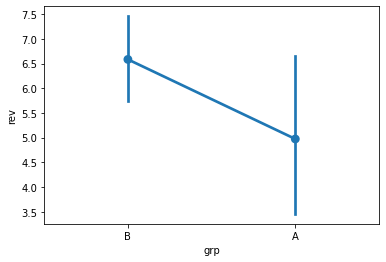

In [26]:
# Сравним средние чеки с доверительными интервалами
sns.pointplot(x="grp", y="rev", data=main)

Проведем тест на нормальность выборок

In [27]:
# Тест на нормальность с помощью библиотеки pingouin
pg.normality(data=main, dv="rev", group="grp", method="normaltest")

,W,pval,normal
B,126821.017822,0.0,False
A,36419.436079,0.0,False


<AxesSubplot:xlabel='rev', ylabel='Count'>

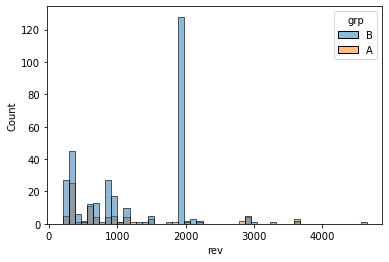

In [28]:
# Тест на нормальность по виду графика распределения
sns.histplot(main[main.rev > 0], x=main[main.rev > 0].rev, bins=50, hue=main.grp)

График распределений и тест Шапиро говорят о ненормальности распределения выборок

<AxesSubplot:xlabel='rev', ylabel='Count'>

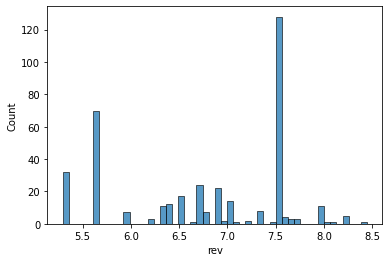

In [29]:
# Проба логарифмирования для приведения к нормальному виду
sns.histplot(main[main.rev > 0], x=np.log(main[main.rev > 0].rev), bins=50)

Логарифмирование не помогло привести выборки к нормальному виду

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

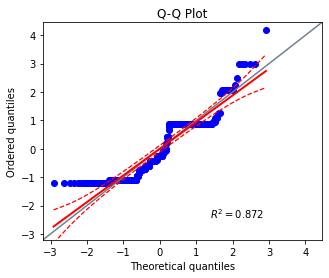

In [30]:
pg.qqplot(main[main.rev > 0]['rev'])

Распределения чеков в обоих группах не является нормальным. На не нормальном распределии рекомендовано проводить U-тест Манна-Уитни, но у нас есть большое количество повторяющихся данных (0 и 1900), U-тест Манна-Уитни слишком чувствителен к таким данным, следовательно для анализа наших данных он не подходит.  

Проверим, есть ли статистически значимые различия по ARPU между тестовой и контрольной группой при помощи Bootstrap.
Н0 - статистически значимых различий нет
Н1 - наблюдаются статистически значимые различия

In [31]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

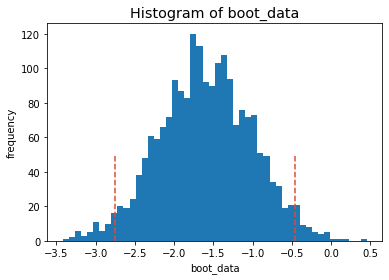

In [32]:
control_group = main[main.grp == 'A']['rev']
test_group = main[main.grp == 'B']['rev']
booted_data = get_bootstrap(control_group, test_group, boot_it=2000)

In [33]:
booted_data["p_value"]

0.00658092193367714

По результатам bootstrap анализа p-value значительно ниже 0.05, следовательно можем отклонить нулевую гипотезу о сходстве выборок по ARPU

**Тестирование при помощи Bootstrap выявило наличие статистически значимых различий между контрольной и тестируемой группами пользователей. Следовательно отклонение показателя ARPU имеет статистически значимое значение.**

#### Определение статистической значимости для конверсии активного пользователя в покупателя

Конверсия является качественным признаком и принимает значение 1 в случае перехода пользователя в покупателя или 0 в случае, когда пользователь остается только пользователем и так и не стал покупателем.

Для статистического анализа качественного признака используется метод Хи-квадрат.

##### Подготовка таблицы для анализа

In [34]:
conversion_df = cr_table[cr_table.is_active == 1]
conversion_df = conversion_df[['id', 'grp', 'converted']]
# Сделаем инверсию для выделения не сконвертировавшихся пользователей
conversion_df['not_converted'] = conversion_df['converted'].apply(lambda x: 1 if x == 0 else 0)
conversion_df.head()

,id,grp,converted,not_converted
1,1627,A,1,0
10,2085,B,0,1
12,2215,B,0,1
42,3391,A,0,1
44,3401,B,0,1


In [35]:
# Рассчитаем сумму сконверторовавшихся и не сконвертировавшихся пользователей по группам
chi_df = conversion_df.groupby('grp')\
    .agg({'converted': 'sum', 'not_converted': 'sum'})
chi_df

,converted,not_converted
grp,,
A,78,1457
B,313,6480


##### Оценка статистической значимости методом Хи-квадрат

Нулевая гипотеза для метода Хи-квадрат состоит в том, что статистически важных различий между выборками нет

In [36]:
print('p-value = ' + str(stats.chi2_contingency(chi_df, correction=False)[1]))

p-value = 0.4280822964525912


**p-value около 42%, следовательно у нас нет оснований отклонить нулевую гипотезу о сходстве выборок. Статистически значимых отличий по конверсии активного пользователя нет.**


### Выводы

По результатам исследования после введения нового механизма оплат конверсия незначительно упала. Но после оценки статистической значимости стало видно, что изменения в конверсии не являются статистически значимыми. 
Показатель ARPU в результате проведения теста вырос значительно: на 32%. В результате статистического анализа, изменение среднего дохода с привлеченного пользователя имеет статистическую значимость.

Исходя из того, что конверсия изменилась незначительно, а денежные показатели потерпели большие изменения, можно сделать вывод, что изменение, которое мы тестируем, касалось именно механизма назначения стоимости товаров, возможно раньше можно было купить только курс целиком, а теперь можно покупать по частям.
Исходя из исследования, введение нового механизма оплат на всех пользователей считаю целесоотбразным. Это увеличит доход компании.

## Реализация функции расчета метрик

### Предварительный анализ

Проверка уникальности пользователей из дополнительного файла

In [37]:
full = groups.merge(group_add, how='inner', on='id')
full.shape

(0, 3)

Пересечение этих двух таблиц говорит о том что значения id из таблицы group_add не пересекаются с таблицей groups. Таблица group_add является дополнением к таблице groups.

In [38]:
full_active = active_studs.merge(group_add, how='inner', left_on='student_id', right_on='id')
full_active.shape

(13, 3)

13 человек из активных пользователей попали в таблицу group_add

Сделаем полный список тех, кто находится в контрольной и тестовой группах

### Функция расчета метрик

In [39]:
def calc_metric(path, metric='cr', group_type='A'):
    """
    Функция расчета метрик принимает на вход: путь к дополнительному файлу с разделением на группы, название метрики, 
    группу, по которой нужно расчитать метрику.

    Parameters
    ----------
    path : str
        Путь к файлу
    metric : str
        Названия метрик могут быть: 'cr', 'arpu', 'avgcheck'
    group_type : str
        Тип группы пользователей: 'A', 'B'
    """

    def cr(active_studs_df, fullgroup, checks):
        active_intest = fullgroup.merge(active_studs_df, how='inner', left_on='id', right_on='student_id')
        active_studs = active_intest[active_intest.grp == group_type]['student_id'].nunique()
        buyers = active_intest.merge(checks, how='inner', on='student_id')
        buy_studs = buyers[buyers.grp == group_type]['student_id'].nunique()
        return buy_studs / active_studs
    
    def average_check(fullgroup, checks):
        checks_df = checks.merge(fullgroup, how='inner', left_on='student_id', right_on='id')
        return checks_df[checks_df.grp == group_type]['rev'].mean()
    
    def arpu(fullgroup, checks, active_studs):
        cr_ = cr(active_studs_df=active_studs, fullgroup=fullgroup, checks=checks)
        active_intest = fullgroup.merge(active_studs, how='inner', left_on='id', right_on='student_id')
        buyers = active_intest.merge(checks, how='inner', on='student_id')
        buy_studs = buyers[buyers.grp == group_type]['student_id'].nunique()
        sum = buyers[buyers.grp == group_type].rev.sum()
        return cr_ * sum / buy_studs

    group = pd.read_csv('groups.csv', sep=';')
    checks = pd.read_csv('checks.csv', sep=';')
    active_studs = pd.read_csv('active_studs.csv')
    
    full_group = group.copy()
    if (path != ''):
        df = pd.read_csv(path)
        full_group = pd.concat([group, df])

    if (metric == 'cr'):
        return cr(active_studs_df=active_studs, fullgroup=full_group, checks=checks)
    elif metric == 'arpu':
        return arpu(fullgroup=full_group, checks=checks, active_studs=active_studs)
    return average_check(fullgroup=full_group, checks=checks)

In [40]:
def calc_metrics(path):
    """
    Функция расчета метрик принимает на вход: путь к дополнительному файлу.
    В результат выполнения - таблица с метриками: 'CR', 'CR_active', 'Avg_check', 'ARPU'

    Parameters
    ----------
    path : str
        Путь к файлу
    
    """

    def calc_cr(group_data, checks_data):
        cr_table = group_data.merge(checks_data, how='left', left_on='id', right_on='student_id')
        cr = cr_table.groupby('grp')\
            .agg({'student_id': 'nunique', 'id': 'nunique'})\
            .rename(columns={'id': 'studs_count', 'student_id': 'payed_studs_count'})
        cr['cr'] = cr['payed_studs_count'] / cr['studs_count']
        return cr[['cr']]
    
    def calc_cr_active(group_data, active_studs_data, checks_data):
        active_table = active_studs_data.merge(group_data, how='inner', left_on='student_id', right_on='id')
        cr_active_table = active_table.merge(checks_data, how='left', left_on='id', right_on='student_id')
        cr_active_table = cr_active_table[['id', 'grp', 'student_id_y']]
        cr_active = cr_active_table.groupby('grp')\
            .agg({'id': 'nunique', 'student_id_y': 'nunique'})\
            .rename(columns={'id': 'active_studs_count', 'student_id_y': 'payed_active_studs_count'})
        cr_active['cr_active'] = cr_active['payed_active_studs_count'] / cr_active['active_studs_count']
        return cr_active[['cr_active']]

    def calc_avg_check(group_data, checks_data):
        avg_check_table = checks_data.merge(group_data, how='inner', left_on='student_id', right_on='id')
        avg_check_table = avg_check_table[['student_id', 'rev', 'grp']]
        avg_check = avg_check_table.groupby('grp')\
            .agg({'rev': 'mean'})\
            .rename(columns={'rev': 'avg_check'})
        return avg_check[['avg_check']]

    def calc_arpu(group_data, checks_data):
        cr_table = calc_cr(group_data, checks_data)
        check_table = checks_data.merge(group_data, how='inner', left_on='student_id', right_on='id')
        sum = check_table.groupby('grp')\
            .agg({'rev': 'sum', 'student_id': 'nunique'})\
            .rename(columns={'rev': 'sum', 'student_id': 'payed_studs_count'})
        arpu = sum.merge(cr_table, how='inner', on='grp')
        arpu['arpu'] = arpu['cr'] * arpu['sum'] / arpu['payed_studs_count']
        return arpu[['arpu']]

    group = pd.read_csv('groups.csv', sep=';')
    checks = pd.read_csv('checks.csv', sep=';')
    active_studs = pd.read_csv('active_studs.csv')
    full_group = group.copy()
    if (path != ''):
        df = pd.read_csv(path)
        full_group = pd.concat([group, df])
    
    cr = calc_cr(full_group, checks)
    cr_active = calc_cr_active(full_group, active_studs, checks)
    avg_check = calc_avg_check(full_group, checks)
    arpu = calc_arpu(full_group, checks)
    all_metrics = cr.merge(cr_active, how='inner', on='grp')
    all_metrics = all_metrics.merge(avg_check, how='inner', on='grp')
    all_metrics = all_metrics.merge(arpu, how='inner', on='grp')
    return all_metrics

In [41]:
calc_metrics(path='group_add.csv')

,cr,cr_active,avg_check,arpu
grp,,,,
A,0.007282,0.050715,860.710280,6.268019
B,0.007247,0.046156,1108.824893,8.036171


Расчитаем показатели с помощью функции конверсию активных пользователей в покупателя

In [42]:
# Конверсия активных пользователей в покупателя в контрольной группе
calc_metric(path='group_add.csv', metric='cr', group_type='A')

0.05071521456436931

In [43]:
# Конверсия активных пользователей в покупателя в тестовой группе
calc_metric(path='group_add.csv', metric='cr', group_type='B')

0.046156107599588415

In [44]:
# Средний чек в контрольной группе
calc_metric(path='group_add.csv', metric='check', group_type='A')

860.7102803738318

In [45]:
# Средний чек в тестовой группе
calc_metric(path='group_add.csv', metric='check', group_type='B')

1108.824893087558

In [46]:
# ARPU в контрольной группе
calc_metric(path='group_add.csv', metric='arpu', group_type='A')

47.34720416124838

In [47]:
# ARPU в тестовой группе
calc_metric(path='group_add.csv', metric='arpu', group_type='B')

58.05879810377774

### Функция построения графиков метрик

Так как данных за длительный период у нас нет, то для отображения используем сравнение между тестовой и контрольной группами текущих значений метрик

In [48]:
def visualize(path):
    # Для построения графиков подготовим сначала таблицу со всеми метриками
    all_metrics = calc_metrics(path).reset_index()
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), tight_layout=True)
    sns.barplot(data=all_metrics, y=all_metrics.grp, x=all_metrics.cr, ax=axes[0, 0])\
        .set(title='Conversion Rate')
    sns.barplot(data=all_metrics, y=all_metrics.grp, x=all_metrics.cr_active, ax=axes[1, 0])\
        .set(title='Active Conversion Rate')
    sns.barplot(data=all_metrics, y=all_metrics.grp, x=all_metrics.avg_check, ax=axes[0, 1])\
        .set(title='Average Check')
    sns.barplot(data=all_metrics, y=all_metrics.grp, x=all_metrics.arpu, ax=axes[1, 1])\
        .set(title='Average Revenue Per User')
    return

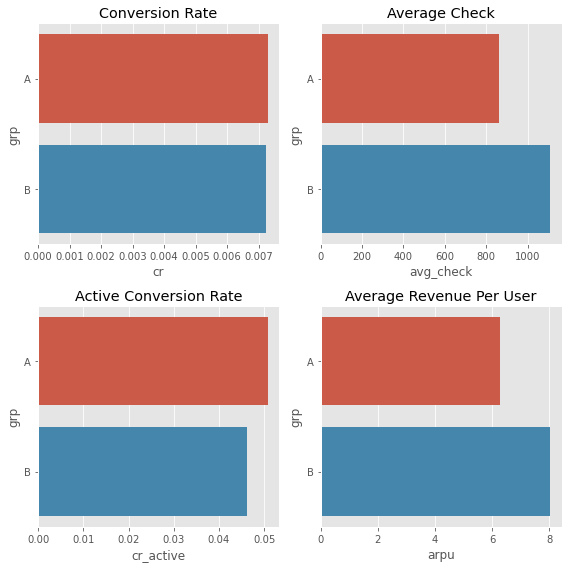

In [49]:
visualize(path='group_add.csv')